In [1]:
from concise.data import attract

dfa = attract.get_metadata()
dfa

Using TensorFlow backend.


,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
0,519,3IVK,3IVK,no,Mus_musculus,GAAACA,6,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
1,574,3IVK,3IVK,no,Mus_musculus,UGGG,4,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
2,464,4KZD,4KZD,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,1.000000**
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,1396,HNRNPAB,ENSG00000197451,no,Homo_sapiens,AUAGCA,6,In vitro splicing assays,AEDB,12426391,other,RRM,1.000000**
4880,1397,HNRNPA1,ENSG00000135486,no,Homo_sapiens,UAGG,4,Immunoprecipitation;U...,AEDB,15506926,UV cross-linking,RRM,1.000000**
4881,1398,PTBP1,ENSG00000011304,no,Homo_sapiens,UUCUUC,6,In vivo splicing assa...,AEDB,14966131,UV cross-linking,RRM,1.000000**


RBPs to check
- UPF1
- PUM2
- DDX3X
- NKRF

In [2]:
dfa_pum2 = dfa[dfa.Gene_name.str.match("PUM2") & \
               dfa.Organism.str.match("Homo_sapiens") & \
               (dfa.Database != "PDB") & \
               (dfa.Experiment_description == "genome-wide in vivo immunoprecipitation")]

In [3]:
dfa_pum2

,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
2609,129,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAAAUA,8,genome-wide in vivo i...,R,18776931,genome-wide in vivo i...,PUF,0.332237**
2610,129,PUM2,ENSG00000055917,no,Homo_sapiens,UGUAUAUA,8,genome-wide in vivo i...,R,18776931,genome-wide in vivo i...,PUF,0.332237**
2611,129,PUM2,ENSG00000055917,no,Homo_sapiens,UGUACAUA,8,genome-wide in vivo i...,R,18776931,genome-wide in vivo i...,PUF,0.332237**


In [4]:
from concise.utils.pwm import PWM
pwm_list = attract.get_pwm_list(dfa_pum2.PWM_id.unique())

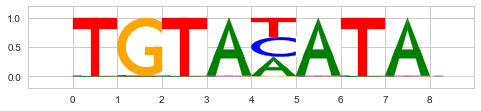

In [5]:
for pwm in pwm_list:
    pwm.plotPWM(figsize=(8,1.5))

- get the data for pum2
- fit a simple model
- check if the PWM initialization helps

## Get the data

In [6]:
import pandas as pd

from concise.preprocessing import encodeDNA, EncodeSplines

In [8]:
def load(split="train", st=None):
    dt = pd.read_csv("../data/RBP/PUM2_{0}.csv".format(split))
    # DNA/RNA sequence
    xseq = encodeDNA(dt.seq) 
    # distance to the poly-A site
    xpolya = dt.polya_distance.as_matrix().reshape((-1, 1))
    # response variable
    y = dt.binding_site.as_matrix().reshape((-1, 1)).astype("float")
    return {"seq": xseq, "dist_polya_raw": xpolya}, y

def data():
    
    train, valid, test = load("train"), load("valid"), load("test")
    
    # transform the poly-A distance with B-splines
    es = EncodeSplines()
    es.fit(train[0]["dist_polya_raw"])
    train[0]["dist_polya_st"] = es.transform(train[0]["dist_polya_raw"])
    valid[0]["dist_polya_st"] = es.transform(valid[0]["dist_polya_raw"])
    test[0]["dist_polya_st"] = es.transform(test[0]["dist_polya_raw"])
    
    #return load("train"), load("valid"), load("test")
    return train, valid, test

train, valid, test = data()

WARNING, x.min() < start for some elements. Truncating them to start: x[x < start] = start
WARNING, x.min() < start for some elements. Truncating them to start: x[x < start] = start


In [9]:
import concise.layers as cl
import keras.layers as kl
import concise.initializers as ci
import concise.regularizers as cr
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping

In [10]:
train[0]["seq"].shape

(17713, 101, 4)

In [11]:
train[0].keys()

dict_keys(['dist_polya_raw', 'dist_polya_st', 'seq'])

In [19]:
def model(train, filters=1, kernel_size=9, pwm_list=None, lr=0.001, use_splinew=True, ext_dist=False):
    seq_length = train[0]["seq"].shape[1]
    if pwm_list is None:
        kinit = "glorot_uniform"
        binit = "zeros"
    else:
        kinit = ci.PSSMKernelInitializer(pwm_list, add_noise_before_Pwm2Pssm=True)
        binit = "zeros"
        
    # sequence
    in_dna = cl.InputDNA(seq_length=seq_length, name="seq")
    inputs = [in_dna]
    x = cl.ConvDNA(filters=filters, 
                   kernel_size=kernel_size, 
                   activation="relu",
                   kernel_initializer=kinit,
                   bias_initializer=binit,
                   name="conv1")(in_dna)
    if use_splinew:
        x = cl.SplineWeight1D(n_bases=10, l2_smooth=0, l2=0, name="spline_weight")(x)
        x = kl.GlobalAveragePooling1D()(x)
    else:
        x = kl.AveragePooling1D(pool_size=4)(x)
        x = kl.Flatten()(x)
        
    if ext_dist:    
        # distance
        in_dist = kl.Input(train[0]["dist_polya_st"].shape[1:], name="dist_polya_st")
        x_dist = cl.SplineT()(in_dist)
        x = kl.concatenate([x, x_dist])
        inputs += [in_dist]
    
    x = kl.Dense(units=1)(x)
    m = Model(inputs, x)
    m.compile(Adam(lr=lr), loss="binary_crossentropy", metrics=["acc"])
    return m

In [20]:
m = model(train, filters=10, use_splinew=False, ext_dist=True)

In [21]:
m.fit(train[0], train[1], epochs=50, validation_data=valid, 
     callbacks=[EarlyStopping(patience=5)])

Train on 17713 samples, validate on 4881 samples
Epoch 1/50
17713/17713 [==============================] - 1s - loss: 0.5125 - acc: 0.7830 - val_loss: 0.8927 - val_acc: 0.3016
Epoch 2/50
17713/17713 [==============================] - 1s - loss: 0.4807 - acc: 0.7882 - val_loss: 0.4649 - val_acc: 0.7988
Epoch 3/50
17713/17713 [==============================] - 1s - loss: 0.4526 - acc: 0.7965 - val_loss: 0.4780 - val_acc: 0.7996
Epoch 4/50
17713/17713 [==============================] - 1s - loss: 0.4463 - acc: 0.7986 - val_loss: 0.4442 - val_acc: 0.8027
Epoch 5/50
17713/17713 [==============================] - 1s - loss: 0.4665 - acc: 0.7810 - val_loss: 0.4513 - val_acc: 0.7996
Epoch 6/50
17713/17713 [==============================] - 1s - loss: 0.4441 - acc: 0.7975 - val_loss: 0.4374 - val_acc: 0.8039
Epoch 7/50
17713/17713 [==============================] - 1s - loss: 0.4356 - acc: 0.8026 - val_loss: 0.4322 - val_acc: 0.8050
Epoch 8/50
17713/17713 [==============================] - 1s -

filter index: 0


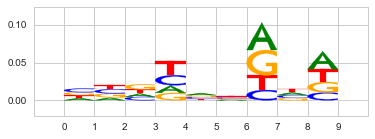

filter index: 1


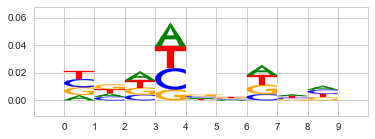

filter index: 2


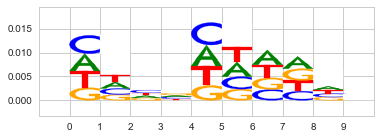

filter index: 3


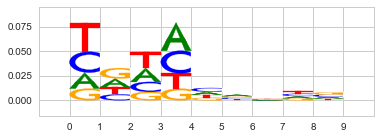

filter index: 4


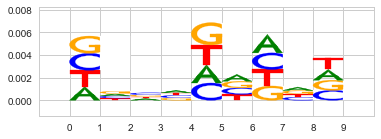

filter index: 5


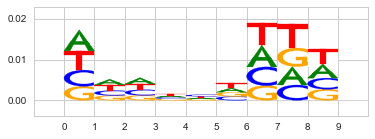

filter index: 6


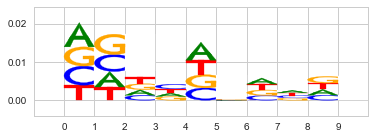

filter index: 7


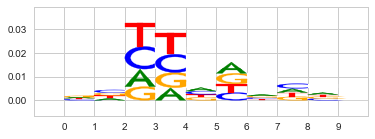

filter index: 8


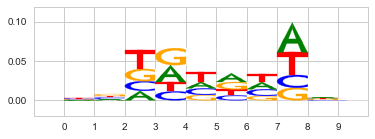

filter index: 9


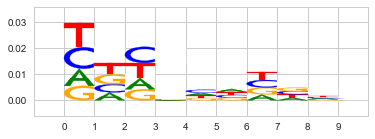

In [148]:
m.get_layer("conv1").plot_weights(plot_type="motif_pwm_info")

In [22]:
m = model(train, filters=16, pwm_list=pwm_list, use_splinew=False, ext_dist=True)

In [23]:
m.fit(train[0], train[1], epochs=50, validation_data=valid, 
     callbacks=[EarlyStopping(patience=5)])

Train on 17713 samples, validate on 4881 samples
Epoch 1/50
17713/17713 [==============================] - 1s - loss: 0.5250 - acc: 0.7957 - val_loss: 0.4888 - val_acc: 0.8183
Epoch 2/50
17713/17713 [==============================] - 1s - loss: 0.4388 - acc: 0.8263 - val_loss: 0.4250 - val_acc: 0.8322
Epoch 3/50
17713/17713 [==============================] - 1s - loss: 0.4052 - acc: 0.8388 - val_loss: 0.4209 - val_acc: 0.8377
Epoch 4/50
17713/17713 [==============================] - 1s - loss: 0.3875 - acc: 0.8465 - val_loss: 0.4037 - val_acc: 0.8412
Epoch 5/50
17713/17713 [==============================] - 1s - loss: 0.3782 - acc: 0.8531 - val_loss: 0.4114 - val_acc: 0.8502
Epoch 6/50
17713/17713 [==============================] - 1s - loss: 0.3769 - acc: 0.8594 - val_loss: 0.4176 - val_acc: 0.8562
Epoch 7/50
17713/17713 [==============================] - 1s - loss: 0.3644 - acc: 0.8618 - val_loss: 0.4139 - val_acc: 0.8605
Epoch 8/50
17713/17713 [==============================] - 1s -

filter index: 0


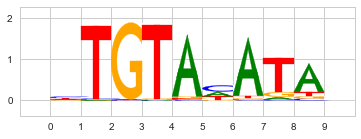

filter index: 1


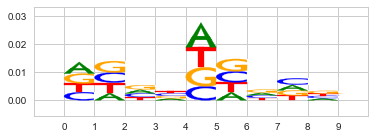

filter index: 2


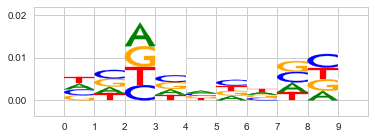

filter index: 3


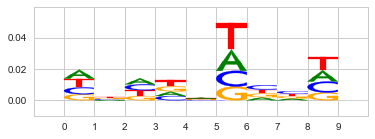

filter index: 4


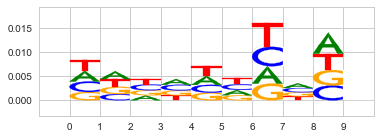

filter index: 5


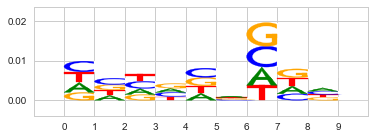

filter index: 6


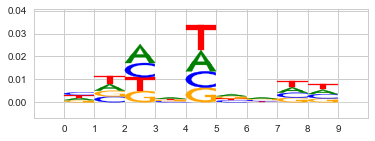

filter index: 7


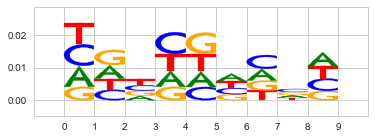

filter index: 8


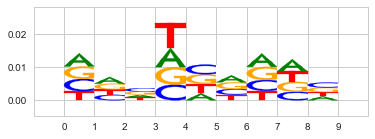

filter index: 9


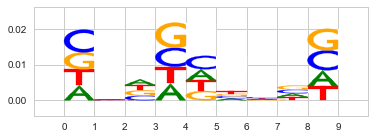

filter index: 10


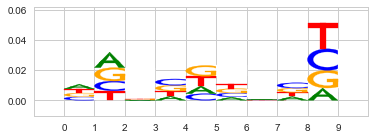

filter index: 11


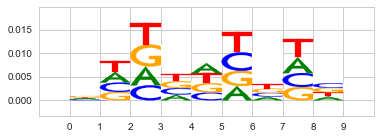

filter index: 12


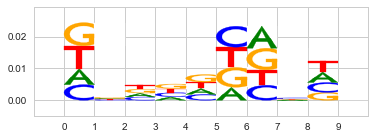

filter index: 13


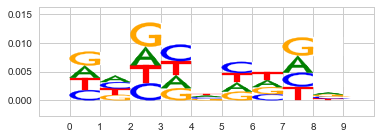

filter index: 14


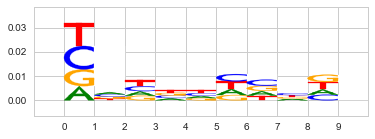

filter index: 15


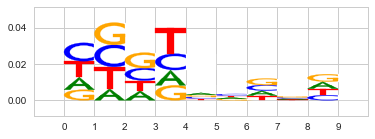

In [166]:
m.get_layer("conv1").plot_weights(plot_type="motif_pwm_info")

In [149]:
# we can see that the performance is better using the initialized motif

In [122]:
m.get_layer("spline_weight").*?

In [123]:
m.get_layer("spline_weight").get_weights()

[array([[ 0.3105,  0.0092,  0.1784,  0.0525,  0.0822,  0.0163,  0.0453, -0.0064,  0.1512,  0.1408],
        [ 0.4   ,  0.0186,  0.2125,  0.0355,  0.1258,  0.0328,  0.0161, -0.0061,  0.118 ,  0.1295],
        [ 0.5456,  0.0922,  0.308 ,  0.0842,  0.213 ,  0.0566,  0.0099, -0.0145,  0.1561,  0.1979],
        [ 0.4251,  0.1034,  0.2794,  0.261 ,  0.1794,  0.0514,  0.0293,  0.0072,  0.1777,  0.2751],
        [-0.2226, -0.051 , -0.0848,  0.3068, -0.1186, -0.0106,  0.0261,  0.0229,  0.031 ,  0.2422],
        [-0.3321, -0.0919, -0.1554,  0.3084, -0.1493, -0.0231, -0.0068,  0.0077, -0.0491,  0.1349],
        [-0.096 , -0.0632, -0.0312,  0.1956, -0.0367, -0.0338, -0.0345,  0.0056, -0.0974, -0.0365],
        [-0.0021, -0.0643, -0.0122,  0.054 , -0.0143, -0.0382, -0.0245,  0.0001, -0.1075, -0.1081],
        [ 0.0551, -0.0483,  0.0085,  0.0126,  0.0131, -0.0324,  0.0066, -0.0089, -0.0916, -0.1097],
        [ 0.0721, -0.023 ,  0.0386,  0.0357,  0.0367, -0.0341,  0.0224, -0.0222, -0.0775, -0.1121]],